# Household spendings

## Exploratory Data Analysis (EDA)

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv("/content/spendings_dataset.csv", sep = ';')
data.head()

,GDP_variation,weight,age,householdSize,isMale,isMarried,isLiterate,nYearsEducation,isUrban,laborStatus,hasAccount,hasLoan,isHouseOwner,yTotalHouseholdSpendings,yTotalHouseholdSpendingsUSD,id
0,0.093446,187,34.0,4,"1,0",1.0,1.0,4.0,1,employed,0.0,1.0,1.0,518.4,48.44235229492184,408112
1,0.093446,95,39.0,8,"1,0",1.0,1.0,0.0,1,employed,0.0,0.0,1.0,12000.0,1121.35078125,99522
2,0.093446,225,53.0,10,"1,0",1.0,1.0,4.0,1,employed,0.0,0.0,1.0,80160.0,7490.6234375,450411
3,0.093446,148,54.0,1,"1,0",0.0,1.0,5.0,1,inactive,0.0,0.0,1.0,13584.0,1269.3690429687522,230464
4,0.093446,221,69.0,5,"1,0",1.0,1.0,0.0,0,employed,0.0,1.0,1.0,3200.0,299.0268798828128,187256


In [3]:
data.shape #we have 4024 samples and 16 features

(4024, 16)

#### The feature "id" isn't significant in our predictive modelling, the same goes for "GDP". It may otherwise be useful for other business insightful tasks !

In [4]:
data = data.drop(columns = ['id', "GDP_variation"], axis = 1)

#### I obeserve that there is no need to have two columns of household spendings, since the only difference between them is the currency, we just converted the currency into another. For precision reasons, I choose the "ytotalHouseholdSpendings" to remain in our predictive modelling.

In [5]:
data = data.drop(columns = "yTotalHouseholdSpendingsUSD")

#### We have 4 variables having object as type of variable : "yTotalHouseholdSpendings", "laborStatus", "isMale", "nYearsEducation". This means that even if I have 99% of the values of a variable being float and then 1% being object, then the variable is considered as an object, which should be cleaned thoroughly !

In [6]:
data.dtypes

weight                        int64
age                         float64
householdSize                 int64
isMale                       object
isMarried                   float64
isLiterate                  float64
nYearsEducation              object
isUrban                       int64
laborStatus                  object
hasAccount                  float64
hasLoan                     float64
isHouseOwner                float64
yTotalHouseholdSpendings     object
dtype: object

### "nYearsEducation" cleaning

In [7]:
data['nYearsEducation'].unique()

array(['4.0', '0.0', '5.0', '1.0', '6.0', '11.0', '3.0', '8.0', '9.0',
       '7.0', nan, '2.0', 'noEducation', '16.0', '10.0', '17.0', '12.0',
       '14.0', '13.0', '15.0'], dtype=object)

In [8]:
data['nYearsEducation'] = data['nYearsEducation'].replace({'noEducation': float(0)}) # "noEducation" means 0 years of education
data['nYearsEducation'] = pd.to_numeric(data['nYearsEducation'], errors='coerce')
data['nYearsEducation'].unique()

array([ 4.,  0.,  5.,  1.,  6., 11.,  3.,  8.,  9.,  7., nan,  2., 16.,
       10., 17., 12., 14., 13., 15.])

### "Labor status" cleaning

In [9]:
data['laborStatus'].unique()

array(['employed', 'inactive', 'unemployed', 'EMPLOYED', nan,
       'un_employed'], dtype=object)

In [10]:
data['laborStatus'] = data['laborStatus'].str.lower() #transforming all strings into lowercase strings
data['laborStatus'] = data['laborStatus'].replace({'inactive': 'unemployed', 'un_employed': 'unemployed'})
#replace "inactive" and "un_employed" with "unemployed"

In [11]:
data["laborStatus"].unique() #Cleaned !

array(['employed', 'unemployed', nan], dtype=object)

#### Let's do one-hot encoding for categorical data in the "LaborStatus" column

In [12]:
data['laborStatus'] = data['laborStatus'].replace({'employed': 1.0, 'unemployed': 0.0})

In [13]:
print(data["laborStatus"].unique()) #Cleaned !

[ 1.  0. nan]


### "isMale" cleaning

In [14]:
data['isMale'].unique()  # This variable has numbers but with commas
                         # So it will be converted into actual float values

array(['1,0', '0,0'], dtype=object)

In [15]:
def convert_float(value):
    cleaned_value = value.split(',')[0]  # split the string by comma and take the first part, which is the integer !
    return float(cleaned_value)

data['isMale'] = data['isMale'].apply(convert_float)

In [16]:
data['isMale'].unique()  # Cleaned !!

array([1., 0.])

### "yTotalHouseholdSpendings" cleaning

In [17]:
print(data.iloc[3611]["yTotalHouseholdSpendings"])  # I observed this anomaly in my analysis of the dataset

noSpendings


#### It proves to be difficult to observe all string values, since there are a highly finite number of unique values, so I will visualize only the string values  

#### Let's access the string values and see if they are identical

In [18]:
def is_float(val):
    try:
        float(val)
        return True
    except ValueError:
        return False

mask = ~data['yTotalHouseholdSpendings'].apply(is_float)

# Access rows with string values
string_values = data[mask]
string_values['yTotalHouseholdSpendings']  # At rows 1917, 3611 and 3684 we have string values with "noSpendings"

1917    noSpendings
3611    noSpendings
3684    noSpendings
Name: yTotalHouseholdSpendings, dtype: object

#### Let's replace noSpendings with just 0

In [19]:
data['yTotalHouseholdSpendings'] = data['yTotalHouseholdSpendings'].replace({"noSpendings": float(0)})
print("replaced string values are :\n At row 3611 : " , data.iloc[3611]["yTotalHouseholdSpendings"], "\n At row 1917 : ", data.iloc[1917]["yTotalHouseholdSpendings"], "\n At row 3684 : ", data.iloc[1917]["yTotalHouseholdSpendings"])

replaced string values are :
 At row 3611 :  0.0 
 At row 1917 :  0.0 
 At row 3684 :  0.0


In [20]:
data['yTotalHouseholdSpendings'] = pd.to_numeric(data['yTotalHouseholdSpendings'], errors='coerce')

In [21]:
print(data['yTotalHouseholdSpendings'].unique())  #cleaned !

[  518.4 12000.  80160.  ...  5932.8  3494.4  4288. ]


### "isUrban", "householdSize" and "weight" converted from integer values to float values as prepation for feature scaling !

In [22]:
data['isUrban'] = data['isUrban'].astype(float)
print(data['isUrban'].dtypes)

float64


In [23]:
data['householdSize'] = data['householdSize'].astype(float)
print(data['householdSize'].dtypes)

float64


In [24]:
data['weight'] = data['weight'].astype(float)
print(data['weight'].dtypes)

float64


### Dataset overview : I observe that there are missing values

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   weight                    4024 non-null   float64
 1   age                       4024 non-null   float64
 2   householdSize             4024 non-null   float64
 3   isMale                    4024 non-null   float64
 4   isMarried                 4024 non-null   float64
 5   isLiterate                4000 non-null   float64
 6   nYearsEducation           4000 non-null   float64
 7   isUrban                   4024 non-null   float64
 8   laborStatus               3991 non-null   float64
 9   hasAccount                4024 non-null   float64
 10  hasLoan                   4015 non-null   float64
 11  isHouseOwner              4024 non-null   float64
 12  yTotalHouseholdSpendings  4021 non-null   float64
dtypes: float64(13)
memory usage: 408.8 KB


In [26]:
data.describe()

,weight,age,householdSize,isMale,isMarried,isLiterate,nYearsEducation,isUrban,laborStatus,hasAccount,hasLoan,isHouseOwner,yTotalHouseholdSpendings
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4000.000000,4000.00000,4024.000000,3991.000000,4024.000000,4015.000000,4024.000000,4.021000e+03
mean,220.400099,45.581262,5.489811,0.735835,0.713469,0.684250,4.09950,0.539761,0.792032,0.047714,0.156164,0.782555,2.267211e+04
std,179.829930,16.030370,2.785281,0.440942,0.452197,0.464872,4.23699,0.498478,0.405905,0.213186,0.363056,0.412559,4.073205e+04
min,-213.000000,-2.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,137.000000,33.000000,4.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,1.000000,6.930000e+03
50%,176.000000,43.000000,5.000000,1.000000,1.000000,1.000000,3.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.358400e+04
75%,233.500000,56.000000,7.000000,1.000000,1.000000,1.000000,6.00000,1.000000,1.000000,0.000000,0.000000,1.000000,2.567040e+04
max,2150.000000,220.000000,22.000000,1.000000,1.000000,1.000000,17.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.347197e+06


In [27]:
data.isnull().sum()

weight                       0
age                          0
householdSize                0
isMale                       0
isMarried                    0
isLiterate                  24
nYearsEducation             24
isUrban                      0
laborStatus                 33
hasAccount                   0
hasLoan                      9
isHouseOwner                 0
yTotalHouseholdSpendings     3
dtype: int64

In [28]:
missing_values = (data.isnull().sum() / len(data)) *100 #Percentage
missing_values = missing_values.drop(missing_values[missing_values == 0].index).sort_values(ascending=False)  #drop the features that have no missing values
missing_data = pd.DataFrame({'Percentage of missing values (%)' :missing_values})
missing_data

,Percentage of missing values (%)
laborStatus,0.820080
isLiterate,0.596421
nYearsEducation,0.596421
hasLoan,0.223658
yTotalHouseholdSpendings,0.074553


Text(0.5, 1.0, 'Percentage of missing data by feature')

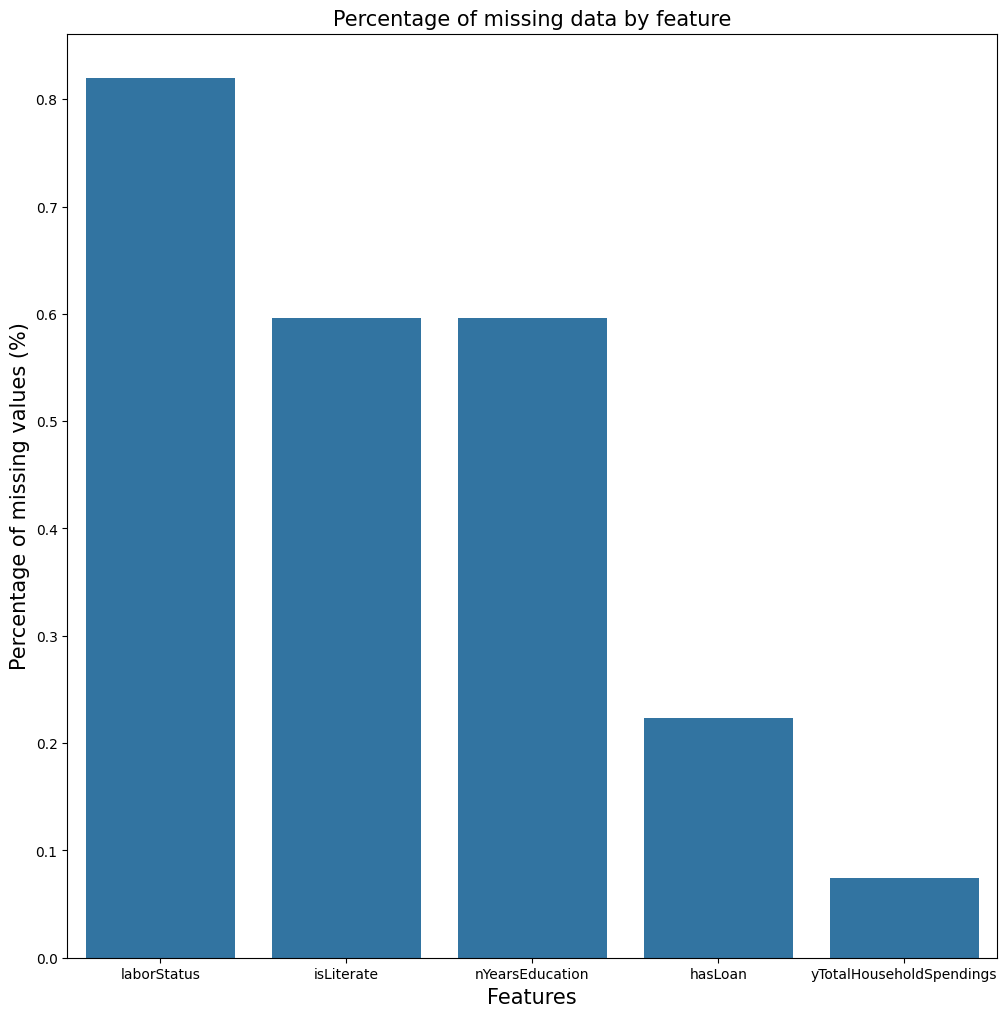

In [29]:
f, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation='horizontal')
sns.barplot(x=missing_values.index, y=missing_values)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percentage of missing values (%)', fontsize=15)
plt.title('Percentage of missing data by feature', fontsize=15)

## Correlation between variables to see if our variables will be dropped or no !

##Handling missing values

###If we drop all the null values, we will be losing 1.15% of our data, so I will try to fill null values by either the mean or using imputer based model

In [30]:
df_cleaned = data.dropna()
df_cleaned.shape

(3978, 13)

### I observe that "nYearsEducation", "isLiterate" are highly correlated with the predictor variable "yTotalHouseholdSpendings" and I decide not to drop the rows corresponding to null values. The same goes for "laborStatus" which is not highly correlated but still can enhance the model's performance

<Axes: >

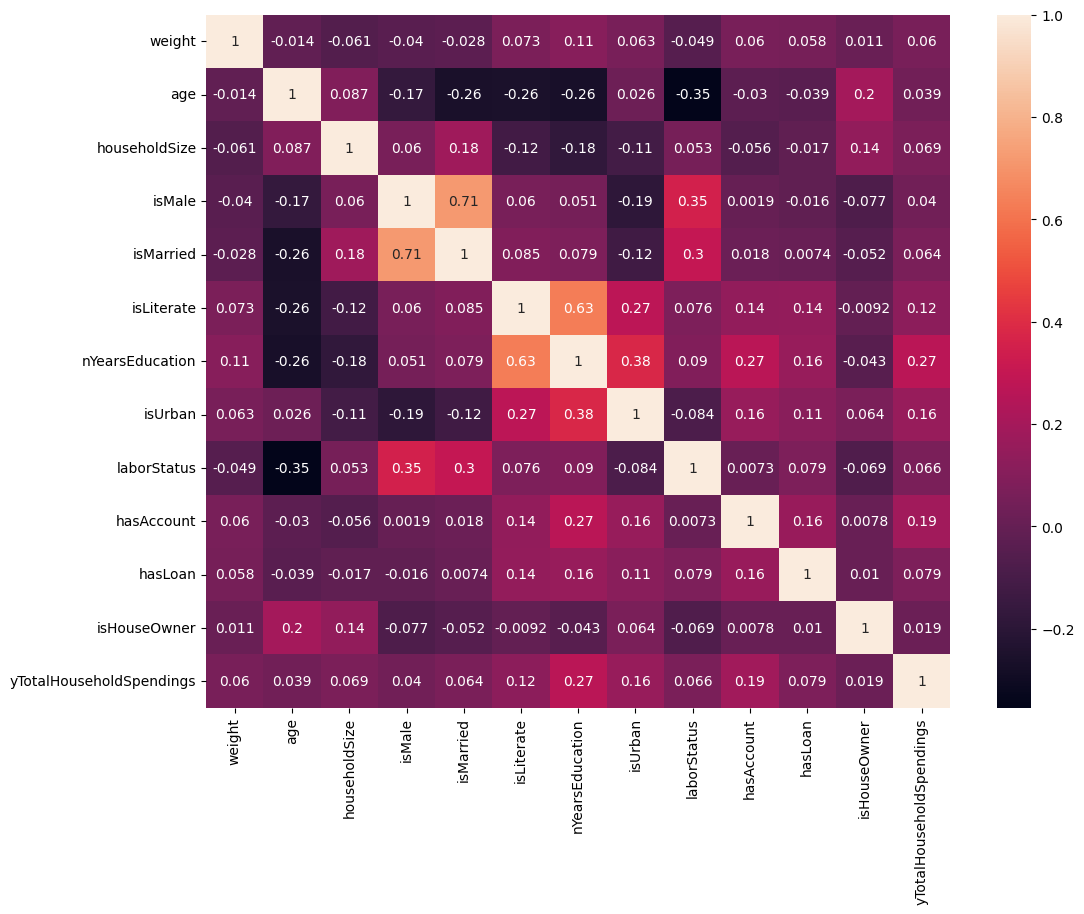

In [31]:
correlation_matrix = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(correlation_matrix, annot = True)

#### Filling the missing predictor variable's data and the "nYearsHouseholdSoendings" by the mean

In [32]:
data['yTotalHouseholdSpendings'].fillna(data['yTotalHouseholdSpendings'].mean(), inplace=True)
data['yTotalHouseholdSpendings'].isnull().sum()  # we have 0 null values

0

In [33]:
data['nYearsEducation'].fillna(data['nYearsEducation'].mean(), inplace=True)
data['nYearsEducation'].isnull().sum()  # we have 0 null values

0

#### I will use the imputer based model on binary features

In [34]:
binary_columns = ['hasLoan', 'isLiterate', 'laborStatus']
imputer = SimpleImputer(strategy='most_frequent')  # Imputer with 'most_frequent' strategy
data[binary_columns] = imputer.fit_transform(data[binary_columns]) # our chosen columns

### Dataset Cleaned !!

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   weight                    4024 non-null   float64
 1   age                       4024 non-null   float64
 2   householdSize             4024 non-null   float64
 3   isMale                    4024 non-null   float64
 4   isMarried                 4024 non-null   float64
 5   isLiterate                4024 non-null   float64
 6   nYearsEducation           4024 non-null   float64
 7   isUrban                   4024 non-null   float64
 8   laborStatus               4024 non-null   float64
 9   hasAccount                4024 non-null   float64
 10  hasLoan                   4024 non-null   float64
 11  isHouseOwner              4024 non-null   float64
 12  yTotalHouseholdSpendings  4024 non-null   float64
dtypes: float64(13)
memory usage: 408.8 KB


## Predictor Variable

### Visualizing the predictor variable's distribution

<ipython-input-36-528bdfaee2ca>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['yTotalHouseholdSpendings'] , fit=norm);



 mu = 22672.11 and sigma = 40711.80



Text(0.5, 1.0, 'yTotalHouseholdSpendings distribution')

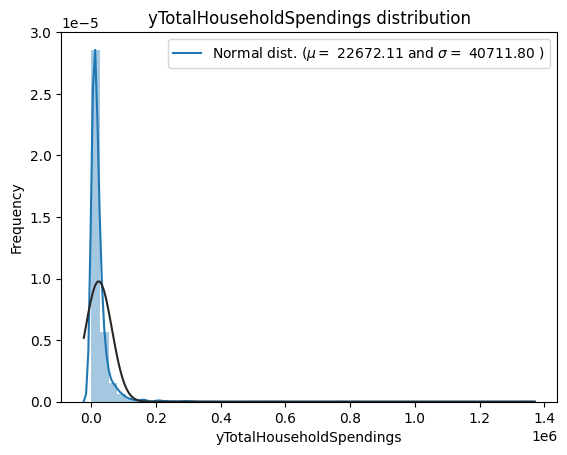

In [36]:
sns.distplot(data['yTotalHouseholdSpendings'] , fit=norm);

(mu, sigma) = norm.fit(data['yTotalHouseholdSpendings'])  # Get the fitted parameters used by the function
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('yTotalHouseholdSpendings distribution')

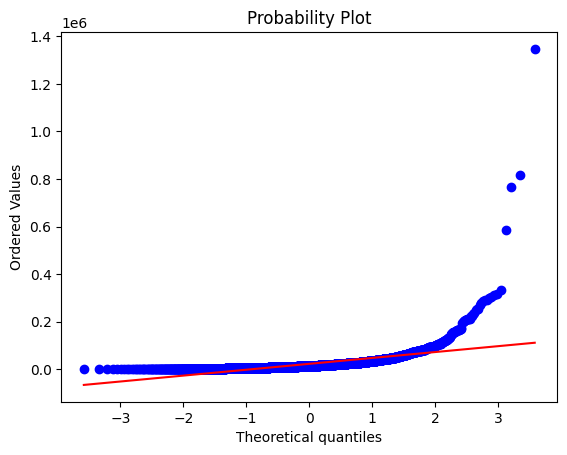

In [37]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['yTotalHouseholdSpendings'], plot=plt)
plt.show()

### In linear regression, we model relationships between variables. When we say the residuals are “normally distributed,” we’re invoking the Central Limit Theorem (CLT). This theorem suggests that the sum or average of many independent, identically distributed random variables tends to be normally distributed — regardless of their original distribution. So, when we talk about the residuals (the differences between actual and predicted values) being normally distributed, we’re leveraging this property for statistical analysis.The normal distribution assumption facilitates techniques like Maximum Likelihood Estimation, making it easier to estimate coefficients and perform hypothesis testing. Hence I will try to approximate the distribution of the target variable into a normal distribution

<ipython-input-38-690bdac86b23>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['yTotalHouseholdSpendings'] , fit=norm);



 mu = 9.31 and sigma = 1.68



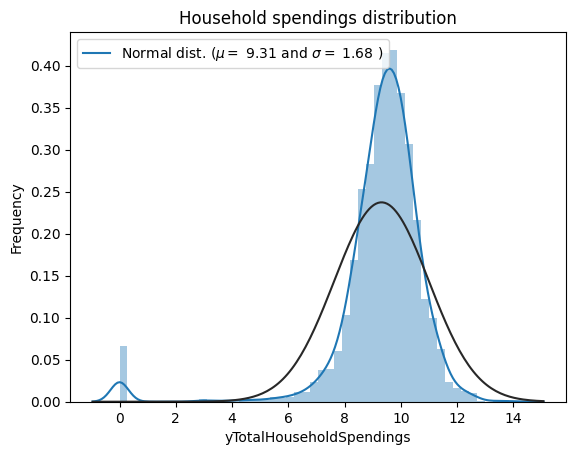

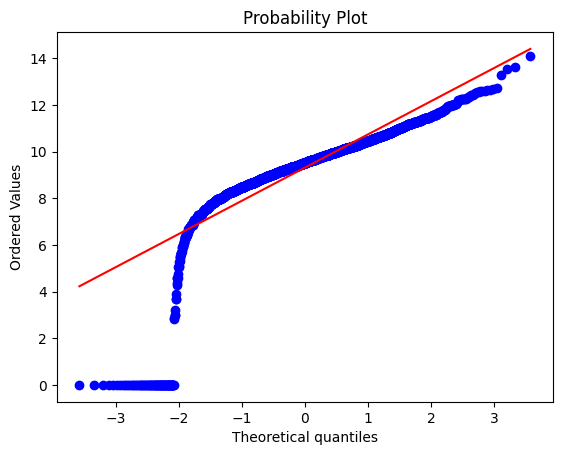

In [38]:

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data["yTotalHouseholdSpendings"] = np.log1p(data["yTotalHouseholdSpendings"])

#Check the new distribution
sns.distplot(data['yTotalHouseholdSpendings'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['yTotalHouseholdSpendings'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Household spendings distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['yTotalHouseholdSpendings'], plot=plt)
plt.show()

## Feature Engineering

In [39]:
X = data.drop(columns='yTotalHouseholdSpendings')
y = data['yTotalHouseholdSpendings']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #test and training splitting

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)    # Scale the features
x_test_scaled = scaler.transform(x_test)

##Model Building

In [40]:
lin_reg = LinearRegression() #simple linear regression
rf_reg = RandomForestRegressor(random_state=42)   #random forest
gb_reg = GradientBoostingRegressor(random_state=42) #gradient boosting

### After the training, I observe that random forest is the best model since it maximizes the Coefficient of determintation $R^2$ and minimizes the Root Mean Square Error, although it's not the best RMSE

In [44]:
lin_reg.fit(x_train_scaled, y_train)
rf_reg.fit(x_train_scaled, y_train)  # Train models
gb_reg.fit(x_train_scaled, y_train)
y_pred_lin = lin_reg.predict(x_test_scaled)
y_pred_rf = rf_reg.predict(x_test_scaled)
y_pred_gb = gb_reg.predict(x_test_scaled)

def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

rmse_lin, r2_lin = evaluate_model(y_test, y_pred_lin)
print(f"Linear Regression - RMSE: {rmse_lin}, R2: {r2_lin}")


rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)                        #Evaluation using RMSE and R2
print(f"Random Forest Regressor - RMSE: {rmse_rf}, R2: {r2_rf}")

rmse_gb, r2_gb = evaluate_model(y_test, y_pred_gb)
print(f"Gradient Boosting Regressor - RMSE: {rmse_gb}, R2: {r2_gb}")

Linear Regression - RMSE: 1.52938138276052, R2: 0.16730638327755476
Random Forest Regressor - RMSE: 1.5780556617191108, R2: 0.11346012839789577
Gradient Boosting Regressor - RMSE: 1.504620743630232, R2: 0.19405069148610543


## Interpretation :     

### I evaluated the performance of three models: Linear Regression, Random Forest, and Gradient Boosting personnalized for regression. The models were evaluated using Root Mean Squared Error (RMSE) and R-squared (R²) metrics.
###<center> Coefficient of determination : $R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$
###<center>&
###<center>Root Mean Square Error : $\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$



### The Gradient Boosting Regressor outperformed the other models with the lowest RMSE of 1.5046 and the highest R² of 0.1941. This indicates that the Gradient Boosting Regressor not only had the **smallest average error** but also explained approximately 19.41% of the variance in the data, making it the most accurate and reliable model for this regression problem. The Linear Regression model also performed reasonably well with an RMSE of 1.5294 and an R² of 0.1673, indicating it captured a moderate amount of the underlying data patterns. The Random Forest Regressor, while still a good model, had the highest RMSE of 1.5781 and the lowest R² of 0.1135, suggesting it was less effective in predicting the Houseshold spendings compared to the other models.

### So, in short, the Gradient Boosting Regressor is the most performant model, providing the most precise predictions and the best fit to the data.